# Lokalizacja punktu w przestrzeni planarnej za pomocą metody trapezowej

### Konfiguracja narzędzia do wizualizacji algorytmu

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [192]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

## Potrzebne klasy i struktury danych

In [201]:
%matplotlib notebook

def count_ab(segment):
    return ((segment.end.y - segment.start.y) / (segment.end.x - segment.start.x),
            segment.start.y - segment.start.x * ((segment.end.y - segment.start.y) / (segment.end.x - segment.start.x)))


def count_y(segment, x):
    a, b = count_ab(segment)
    return a * x + b

class Point:
    def __init__(self, point):
        self.x = point[0]
        self.y = point[1]
    
    def draw(self):
        return [self.x, self.y]
    
    def __str__(self):
        return f'({self.x},{self.y})'

class Segment:
    def __init__(self, segment):
        self.segment = segment
        self.start = Point(segment[0])
        self.end = Point(segment[1])
    
    def draw(self):
        return [self.start.draw(), self.end.draw()]
    
    def __str__(self):
        return f'[{str(self.start)}, {str(self.end)}]'
    
    
class Trapezoid:
    def __init__(self, leftp, rightp, top, bottom, left_top = None, left_bottom = None, right_bottom = None, right_top = None):
        self.leftp = Point(leftp)
        self.rightp = Point(rightp)
        self.top = Segment(top)
        self.bottom = Segment(bottom)
        self.left_top = left_top
        self.left_bottom = left_bottom
        self.right_bottom = right_bottom
        self.right_top = right_top
        
    def draw(self):
        res = []
        res.append((self.leftp.x, count_y(self.bottom, self.leftp.x)))
        res.append((self.rightp.x, count_y(self.bottom, self.rightp.x)))
        res.append((self.rightp.x, count_y(self.top, self.rightp.x)))
        res.append((self.leftp.x, count_y(self.top, self.leftp.x)))
        res.append(res[0])
        return [[[res[i][0], res[i][1]], [res[i + 1][0], res[i + 1][1]]] for i in range(len(res)-1)]
    

In [202]:
%matplotlib notebook
tmp = Trapezoid((0,0), (10,10), [(0,10), (5,10)], [(0,1), (5, 3)])
tmp2 = Trapezoid((10,2), (13,2), [(12, 8), (13, 9)], [(11, 2), (12, 2)])
trapezoidal_map = []
trapezoidal_map.extend(tmp.draw())
trapezoidal_map.extend(tmp2.draw())

<IPython.core.display.Javascript object>


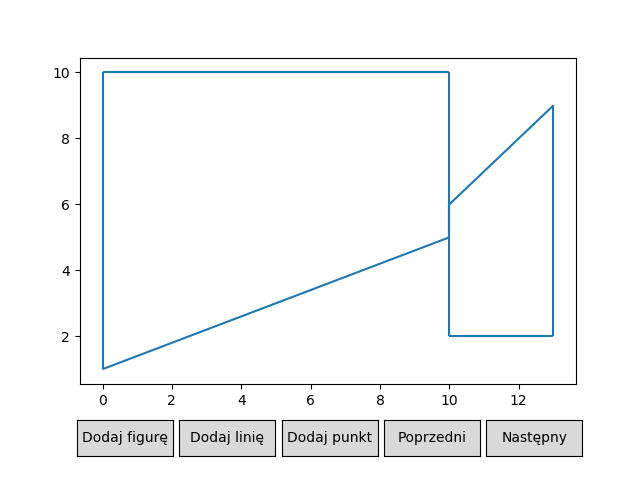

In [203]:
%matplotlib notebook
scenes = [Scene([], [LinesCollection(trapezoidal_map)])]

plot = Plot(scenes)
plot.draw()

### Funkcje pomocniczne

In [204]:
%matplotlib notebook

def prepare_data(segments):
    points = []
    new_segments = []
    MAX_X = MIN_X = MAX_Y = MIN_Y = 0
    point_set = set()
    for segment in segments:
        new_segment = Segment(segment)
        start = new_segment.start
        end = new_segment.end
        new_segments.append(new_segment)
        for point in [start, end]:
            if (point.x, point.y) not in point_set:
                point_set.add((point.x, point.y))
                points.append(point)
                MIN_Y = min(MIN_Y, point.y)
                MIN_X = min(MIN_X, point.x)
                MAX_Y = max(MAX_Y, point.y)
                MAX_X = max(MAX_X, point.x)

    return points, new_segments, MAX_Y, MIN_Y, MAX_X, MIN_X
        

def draw_collection(elements):
    return [ element.draw() for element in elements]

# Narysuj odcinki lub wielokąty oraz punkt który ma zostać odnaleziony

<IPython.core.display.Javascript object>


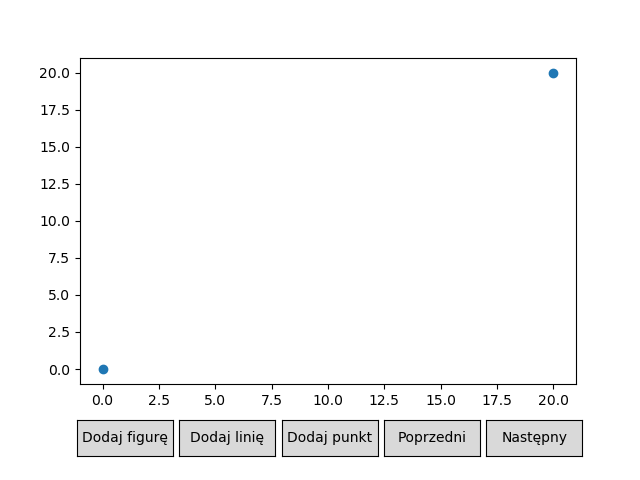

In [205]:
plot_to_draw = Plot([Scene([PointsCollection([[0,0], [20, 20]])],[])])
plot_to_draw.draw()

### Zapisywanie to do formatu json

In [206]:
%matplotlib notebook

figure_from_previous_plot = plot_to_draw.get_added_figure()
segments_from_previous_plot = plot_to_draw.get_added_lines()
points_from_previous_plot = plot_to_draw.get_added_points()
scenes = [Scene([], figure_from_previous_plot),
          Scene([], segments_from_previous_plot),
          Scene(points_from_previous_plot, []),]
with open('plot.json', 'w') as file:
    file.write(Plot(scenes).toJson())

### Odczytanie danych wejściowych z pliku json

In [207]:
%matplotlib notebook

with open('plot.json', 'r') as file:
    json = file.read()
helper_plot = Plot(json=json)
elements = helper_plot.scenes[0].lines[0].lines
lines = helper_plot.scenes[1].lines[0].lines
point_to_find = Point(helper_plot.scenes[2].points[0].points[0])

segments = elements + lines

points, new_segments, MAX_Y, MIN_Y, MAX_X, MIN_X = prepare_data(segments)

scenes = [Scene(
    [PointsCollection(draw_collection(points)), PointsCollection(draw_collection([point_to_find]))],
    [LinesCollection(draw_collection(new_segments))]
    )]

plot = Plot(scenes)
plot.draw()

IndexError: list index out of range

# Główny algorytm

In [209]:
def find_point_location(point_to_find, segments, points, MAX_Y, MIN_Y, MAX_X, MIN_X):
    print(point_to_find, segments, points, MAX_Y, MIN_Y, MAX_X, MIN_X)
    # TO DO
    
find_point_location(point_to_find, new_segments, points, MAX_Y, MIN_Y, MAX_X, MIN_X)



(12.395223049517107,18.755761539234836) [<__main__.Segment object at 0x001FDB30>, <__main__.Segment object at 0x001FDD90>, <__main__.Segment object at 0x1172A0F0>, <__main__.Segment object at 0x00A46B50>, <__main__.Segment object at 0x00A46150>, <__main__.Segment object at 0x00A462B0>, <__main__.Segment object at 0x00A46B10>, <__main__.Segment object at 0x0FAD6770>, <__main__.Segment object at 0x119B4BD0>, <__main__.Segment object at 0x00A46D30>, <__main__.Segment object at 0x119B4F90>, <__main__.Segment object at 0x119B4910>] [<__main__.Point object at 0x001FDEF0>, <__main__.Point object at 0x001FDFD0>, <__main__.Point object at 0x1172A3D0>, <__main__.Point object at 0x00A46030>, <__main__.Point object at 0x00A46BF0>, <__main__.Point object at 0x00A46C10>, <__main__.Point object at 0x00A46DB0>, <__main__.Point object at 0x0FAD6190>, <__main__.Point object at 0x119B4B30>, <__main__.Point object at 0x119B4A30>, <__main__.Point object at 0x00A46710>, <__main__.Point object at 0x119B41F0>